## Download dataset


###1. Login to kaggle, choose Your Profile, and click account
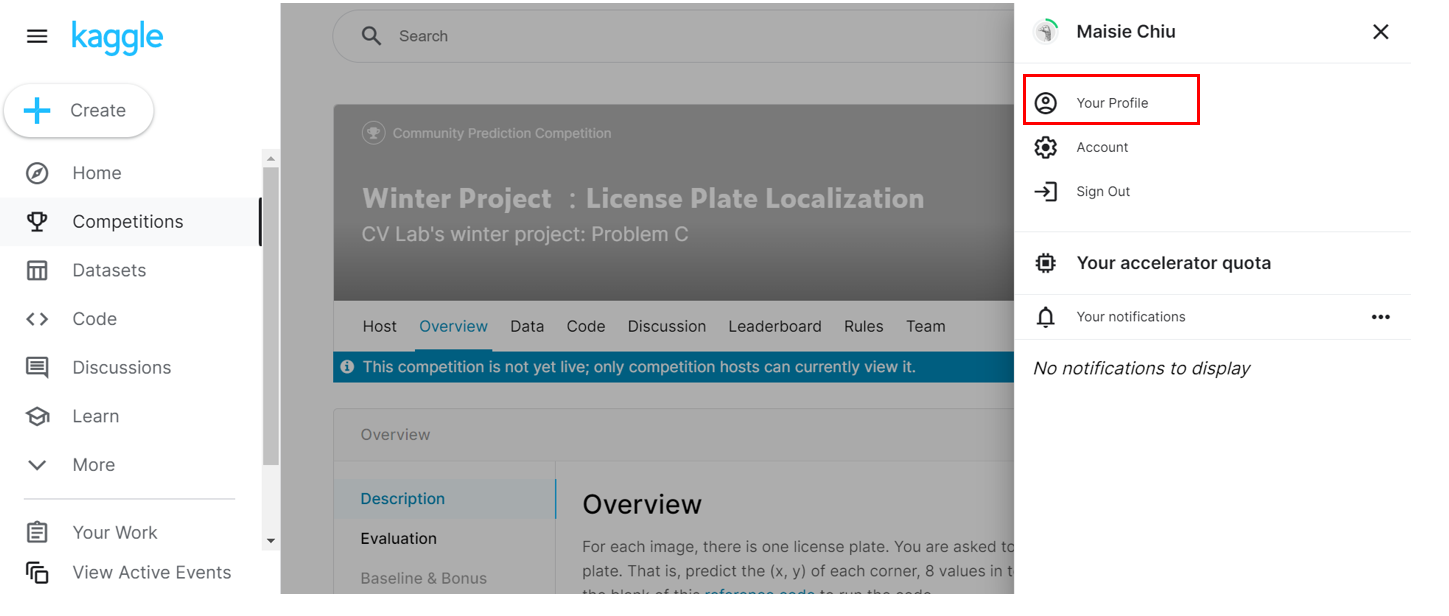

###2. Click on Create New API Token - It will download kaggle.json file on your machine.
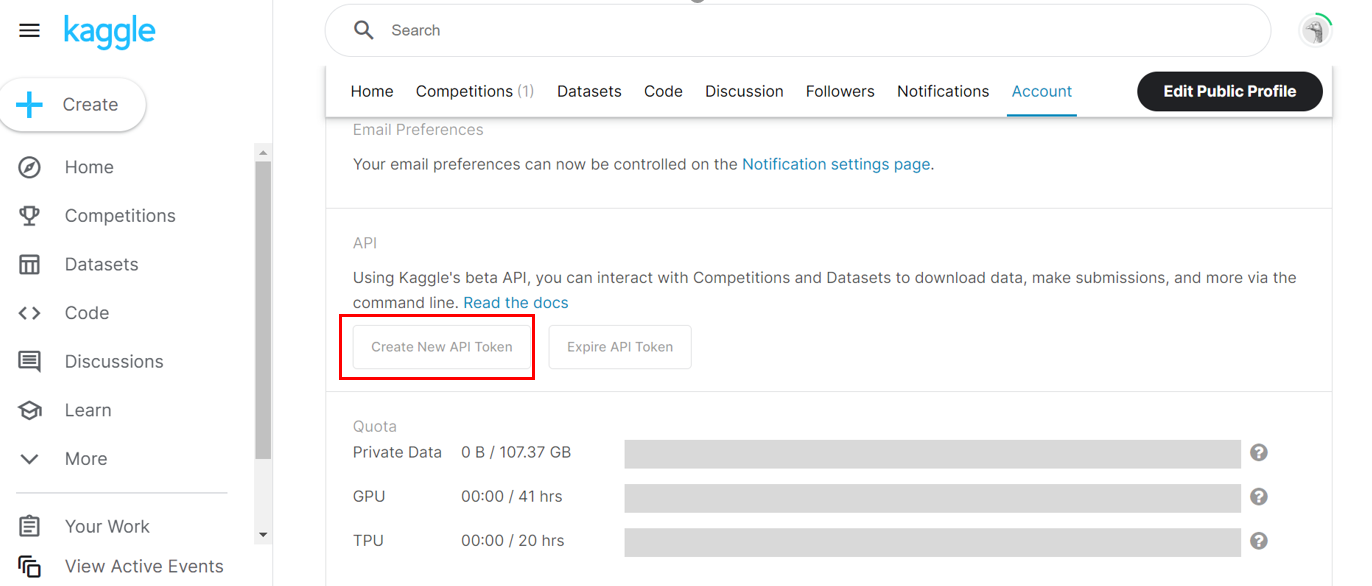


###3.Upload kaggle.json to google drive and run the following commands:

In [ ]:
##link the file at your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
## Opened the access to kaggle dataset
import os
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# unzip dataset
!kaggle competitions download -c problem-b-license-plate-localization
!unzip problem-b-license-plate-localization.zip

Streaming output truncated to the last 5000 lines.
  inflating: ccpd6000/test_images/1001.jpg  
  inflating: ccpd6000/test_images/1002.jpg  
  inflating: ccpd6000/test_images/1003.jpg  
  inflating: ccpd6000/test_images/1004.jpg  
  inflating: ccpd6000/test_images/1005.jpg  
  inflating: ccpd6000/test_images/1006.jpg  
  inflating: ccpd6000/test_images/1007.jpg  
  inflating: ccpd6000/test_images/1008.jpg  
  inflating: ccpd6000/test_images/1009.jpg  
  inflating: ccpd6000/test_images/1010.jpg  
  inflating: ccpd6000/test_images/1011.jpg  
  inflating: ccpd6000/test_images/1012.jpg  
  inflating: ccpd6000/test_images/1013.jpg  
  inflating: ccpd6000/test_images/1014.jpg  
  inflating: ccpd6000/test_images/1015.jpg  
  inflating: ccpd6000/test_images/1016.jpg  
  inflating: ccpd6000/test_images/1017.jpg  
  inflating: ccpd6000/test_images/1018.jpg  
  inflating: ccpd6000/test_images/1019.jpg  
  inflating: ccpd6000/test_images/1020.jpg  
  inflating: ccpd6000/test_images/1021.jpg  
  in

# Init and Utility

In [ ]:
import warnings
import os
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython import display
from skimage import util
from skimage.transform import ProjectiveTransform, warp

import numpy as np
import random
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torchvision.models as models
import cv2
import shutil
import warnings

In [ ]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [ ]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


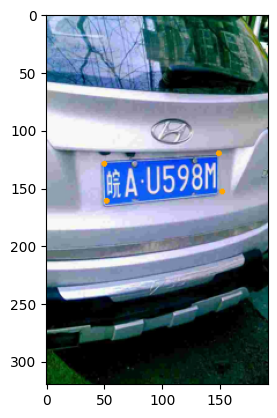

In [ ]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of
                bottom-right, bottom-left, top-left, top-right corners.
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)

        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]

        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet.children())[:-2],
            ConvBlock(512, 512),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        # TODO : add ouput layer to predict position
        self.regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 8),
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        kpt_b = self.regression(features)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda' if torch.cuda.is_available() else 'cpu'    # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.4679, device='cuda:0', grad_fn=<MeanBackward0>)


# Training

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

lr: 0.0009
Epoch 000:
train loss: 0.05094240314792842
valid loss: 0.02710818642129501
train mse: 0.00635671817799448
valid mse: 0.001142233827461799
lr: 0.0009
Epoch 001:
train loss: 0.03106233391057079
valid loss: 0.014313829286644856
train mse: 0.0016227886402096676
valid mse: 0.0003741719114865797
lr: 0.0009
Epoch 002:
train loss: 0.025526946845153966
valid loss: 0.03601827121650179
train mse: 0.0010815405786464302
valid mse: 0.0016660137509461493
lr: 0.0009
Epoch 003:
train loss: 0.023485991063838203
valid loss: 0.017669028121357164
train mse: 0.0009542730850929123
valid mse: 0.0005366460303775966
lr: 0.0009
Epoch 004:
train loss: 0.021101325501998267
valid loss: 0.016074871690943838
train mse: 0.0007590144014708737
valid mse: 0.0005007767281009971
lr: 0.0009
Epoch 005:
train loss: 0.019391602211787054
valid loss: 0.019111912604421376
train mse: 0.0006465949473446624
valid mse: 0.0006535322225924271
lr: 0.0009
Epoch 006:
train loss: 0.018002905937222143
valid loss: 0.01983546791598

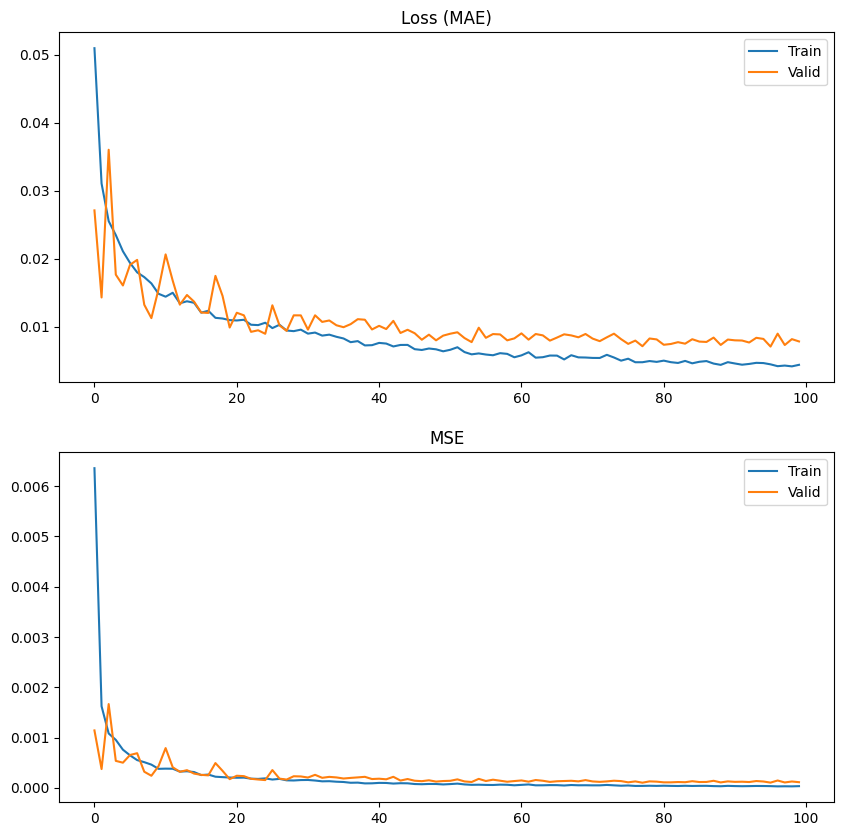

In [ ]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=9e-4)
        self.max_epoch = 100 #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': [], 'train_mse': [], 'valid_mse': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss, train_mse = self.train() # train 1 epoch
            valid_loss, valid_mse = self.valid() # valid 1 epoch
            self.visul()              # visualization
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            print('train mse:', train_mse)
            print('valid mse:', valid_mse)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            metrics['train_mse'].append(train_mse)
            metrics['valid_mse'].append(valid_mse)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_mse']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
        ax[0].set_title('Loss (MAE)')
        ax[0].plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax[0].plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax[0].legend()
        ax[1].set_title('MSE')
        ax[1].plot(range(self.epoch + 1), metrics['train_mse'], label='Train')
        ax[1].plot(range(self.epoch + 1), metrics['valid_mse'], label='Valid')
        ax[1].legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            # TODO
            # step 1 caculate the loss
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()
            # step 3 update parameters using optimizer
            self.optimizer.step()

            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [ ]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
# model.load_state_dict(torch.load('runs/Jan.14 11:12:28/training_result/model.pth'))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            # print(kpt)
            # print(kpt[0:-1:2])
            # print(kpt[1::2])
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-17-bd7b082c3e05>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

testing_result/Feb.02 16:08:56


100%|██████████| 3000/3000 [02:06<00:00, 23.76it/s]


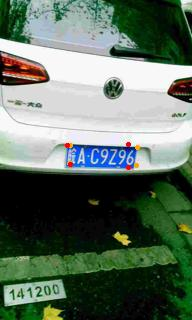

In [ ]:
display.Image(str(log_dir / '001' / '026.jpg')) # A visualization of validation data in epoch 4

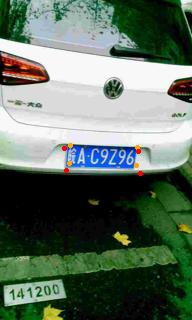

In [ ]:
display.Image(str(log_dir / '003' / '026.jpg')) # A visualization of validation data in epoch 10

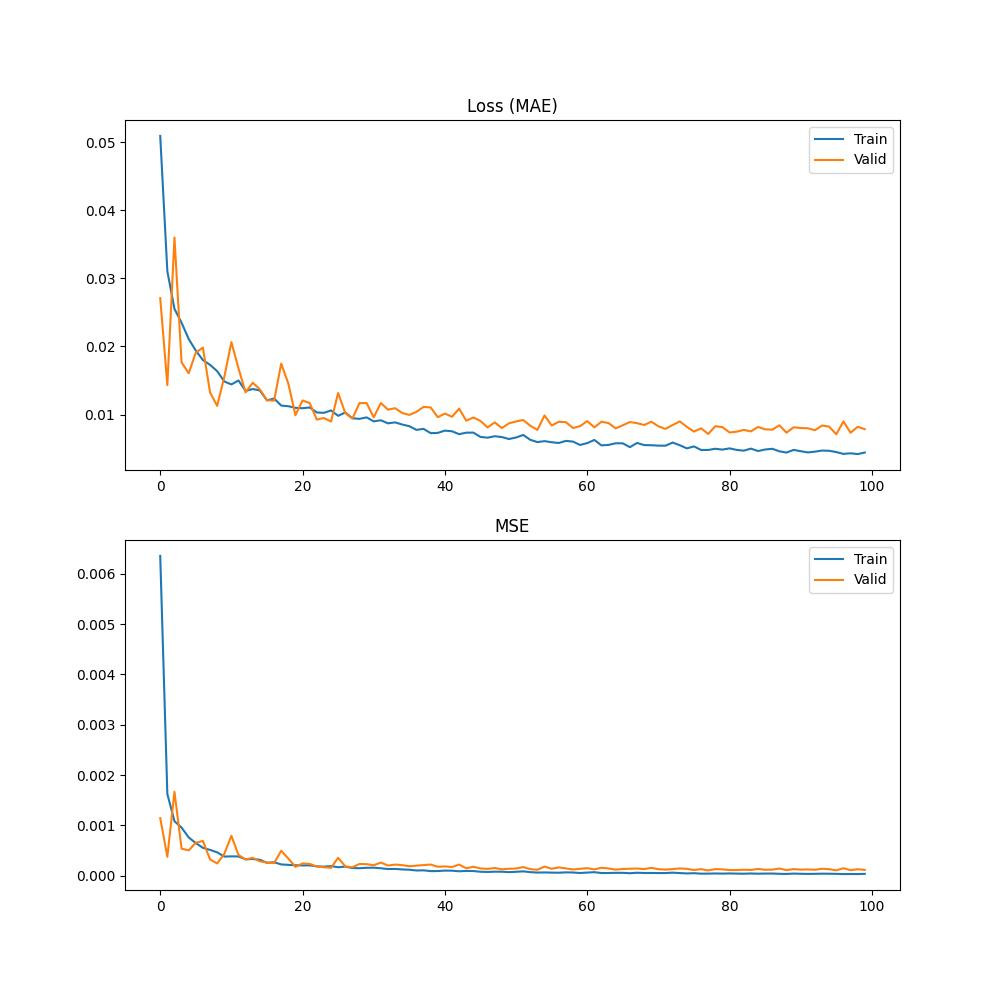

In [ ]:
display.Image(str(log_dir / 'training_result/metrics.jpg')) # Loss

# Report

After completing the template code, it is just up to defining the model architecture to get the model to achieve a low RMSE score. At first, I designed my model to be using the predefined ConvBlock layer and some activation ReLU layers, but I can only achieve a score of 36 RMSE. Then, I tried to use a larger ConvBlock layers and combining it with Dropouts and MaxPooling layer, but in the end I can only get a score of 35 RMSE. Then, I tried to extract features using Resnet18 just like in the hint. With Resnet18 to extract features ad AveragePooling layer, I instantly got a score of 11 on my RMSE and improving it until I hit a score of 8.9. Then, I wanted to use the ConvBlock layer in my model, so I added a ConvBlock layer after the resnet18 layer and I am able to achieve a RMSE score of 8.7.

### Final RMSE Score
![RMSE](https://drive.google.com/uc?export=view&id=1DbmwdiSRl6OEOchH2nK_UCYFNh9KA1U5)

The 2 best RMSE score that I achieved are 8.79837 and 8.94850. However, I believe that with my current model, if I was to increase the epoch from 100 to 150 or maybe 200, I can achieve a slightly better RMSE score.